In [1]:
import requests
import pandas as pd

# Load the dataset
file_path = 'dataset_space_API_past_launches_raw.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()



,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,NaN,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,NaN,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,NaN,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,NaN,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857


In [2]:
# Get the total number of columns and rows in the dataset
total_columns = data.shape[1]
total_rows = data.shape[0]

total_columns, total_rows




(17, 94)

In [3]:
# Calculating the percentage of missing values in each column
missing_values_percent = data.isnull().mean() * 100

# Identifying numeric and categorical columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Handling missing values for PayloadMass (example)
# Here, we'll replace missing values with the mean of the column
data['PayloadMass'].fillna(data['PayloadMass'].mean(), inplace=True)

# Calculating the number of launches at each site
launch_counts = data['LaunchSite'].value_counts()

missing_values_percent, numeric_cols, categorical_cols, launch_counts



(FlightNumber       0.000000
 Date               0.000000
 BoosterVersion     0.000000
 PayloadMass        6.382979
 Orbit              0.000000
 LaunchSite         0.000000
 Outcome            0.000000
 Flights            0.000000
 GridFins           0.000000
 Reused             0.000000
 Legs               0.000000
 LandingPad        31.914894
 Block              4.255319
 ReusedCount        0.000000
 Serial             0.000000
 Longitude          0.000000
 Latitude           0.000000
 dtype: float64,
 Index(['FlightNumber', 'PayloadMass', 'Flights', 'Block', 'ReusedCount',
        'Longitude', 'Latitude'],
       dtype='object'),
 Index(['Date', 'BoosterVersion', 'Orbit', 'LaunchSite', 'Outcome',
        'LandingPad', 'Serial'],
       dtype='object'),
 CCSFS SLC 40       55
 KSC LC 39A         22
 VAFB SLC 4E        13
 Kwajalein Atoll     4
 Name: LaunchSite, dtype: int64)

In [4]:
# Define the mapping for the Outcome column again
outcome_mapping = {
    "True Ocean": 1,
    "False Ocean": 0,
    "True RTLS": 1,
    "False RTLS": 0,
    "True ASDS": 1,
    "False ASDS": 0,
    "None ASDS": 0,
    "None None": 0
}

# Apply the mapping to the Outcome column in the original dataset
data['Outcome'] = data['Outcome'].map(outcome_mapping)

print(data['Outcome'].dtype)


# Count the number of successful and unsuccessful outcomes
outcome_counts = data['Outcome'].value_counts()
outcome_counts



int64


1    60
0    34
Name: Outcome, dtype: int64

In [5]:
# Fill missing values in 'PayloadMass' and 'Block' columns with the mean
data_filled = data.copy()
data_filled['PayloadMass'].fillna(data_filled['PayloadMass'].mean(), inplace=True)
data_filled['Block'].fillna(data_filled['Block'].mean(), inplace=True)

# Drop 'LandingPad' column
data_filled.drop(columns=['LandingPad'], inplace=True)

# Verify the missing values are handled
data_filled.isnull().sum()

# Extract year from the 'Date' column
data_filled['Year'] = pd.to_datetime(data_filled['Date']).dt.year

# Drop the original 'Date' column
data_filled.drop(columns=['Date'], inplace=True)

# Convert categorical variables to dummy variables (one-hot encoding)
data_encoded = pd.get_dummies(data_filled, columns=['BoosterVersion', 'Orbit', 'LaunchSite', 'Serial'])

# Display the first few rows to verify the changes
data_encoded.head()



,FlightNumber,PayloadMass,Outcome,Flights,GridFins,Reused,Legs,Block,ReusedCount,Longitude,...,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,Serial_Merlin1A,Serial_Merlin2A,Serial_Merlin2C,Serial_Merlin3C
0,1,20.000000,0,1,False,False,False,3.5,0,167.743129,...,0,0,0,0,0,0,1,0,0,0
1,2,5919.165341,0,1,False,False,False,3.5,0,167.743129,...,0,0,0,0,0,0,0,1,0,0
2,4,165.000000,0,1,False,False,False,3.5,0,167.743129,...,0,0,0,0,0,0,0,0,1,0
3,5,200.000000,0,1,False,False,False,3.5,0,167.743129,...,0,0,0,0,0,0,0,0,0,1
4,6,5919.165341,0,1,False,False,False,1.0,0,-80.577366,...,0,0,0,0,0,0,0,0,0,0


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, log_loss

# Define features (X) and target (y)
X = data_encoded.drop(columns=['Outcome'])
y = data_encoded['Outcome']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)
log_loss_value = log_loss(y_test, y_prob)



# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print('accuracy:',accuracy)

print('\n',classification_rep)


print(f"AUC: {auc}")
print(f"Log Loss: {log_loss_value}")

confusion_mat



accuracy: 0.7894736842105263

               precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.77      0.91      0.83        11

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77        19
weighted avg       0.80      0.79      0.78        19

AUC: 0.8977272727272727
Log Loss: 0.3950495068084951


array([[ 5,  3],
       [ 1, 10]], dtype=int64)

In [10]:

from sklearn.tree import DecisionTreeClassifier


# 训练决策树模型
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# 进行预测
y_pred_tree = decision_tree_model.predict(X_test)
y_prob_tree = decision_tree_model.predict_proba(X_test)[:, 1]

# 计算准确率
accuracy_tree = accuracy_score(y_test, y_pred_tree)

# 计算AUC
auc_tree = roc_auc_score(y_test, y_prob_tree)

# 计算Log Loss
log_loss_tree = log_loss(y_test, y_prob_tree)

# 生成分类报告和混淆矩阵
classification_rep_tree = classification_report(y_test, y_pred_tree)
confusion_mat_tree = confusion_matrix(y_test, y_pred_tree)

# 输出结果
print(f"Accuracy: {accuracy_tree}")
print(f"Classification Report:\n{classification_rep_tree}")
print(f"Confusion Matrix:\n{confusion_mat_tree}")
print(f"AUC: {auc_tree}")
print(f"Log Loss: {log_loss_tree}")


Accuracy: 0.6842105263157895
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.73      0.73      0.73        11

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19

Confusion Matrix:
[[5 3]
 [3 8]]
AUC: 0.6761363636363636
Log Loss: 10.907108271671298


In [11]:
from sklearn.ensemble import RandomForestClassifier

# 训练随机森林模型
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

# 进行预测
y_pred_rf = random_forest_model.predict(X_test)
y_prob_rf = random_forest_model.predict_proba(X_test)[:, 1]

# 计算准确率
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# 计算AUC
auc_rf = roc_auc_score(y_test, y_prob_rf)

# 计算Log Loss
log_loss_rf = log_loss(y_test, y_prob_rf)

# 生成分类报告和混淆矩阵
classification_rep_rf = classification_report(y_test, y_pred_rf)
confusion_mat_rf = confusion_matrix(y_test, y_pred_rf)

# 输出结果
print(f"Accuracy: {accuracy_rf}")
print(f"Classification Report:\n{classification_rep_rf}")
print(f"Confusion Matrix:\n{confusion_mat_rf}")
print(f"AUC: {auc_rf}")
print(f"Log Loss: {log_loss_rf}")


Accuracy: 0.7894736842105263
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.77      0.91      0.83        11

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77        19
weighted avg       0.80      0.79      0.78        19

Confusion Matrix:
[[ 5  3]
 [ 1 10]]
AUC: 0.8636363636363636
Log Loss: 0.45216218374549383


In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# 定义特征 (X) 和目标 (y)
X = data_encoded.drop(columns=['Outcome'])
y = data_encoded['Outcome']

# 初始化模型
model = LogisticRegression(max_iter=1000)

# 使用K-fold交叉验证进行模型评估
cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold交叉验证

# 打印交叉验证结果
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {cv_scores.mean()}')


Cross-validation scores: [0.57894737 0.73684211 0.73684211 0.84210526 0.77777778]
Mean CV score: 0.7345029239766082


C:\Users\Quchang\AppData\Local\Temp\ipykernel_30800\3206159606.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_filled.corr()


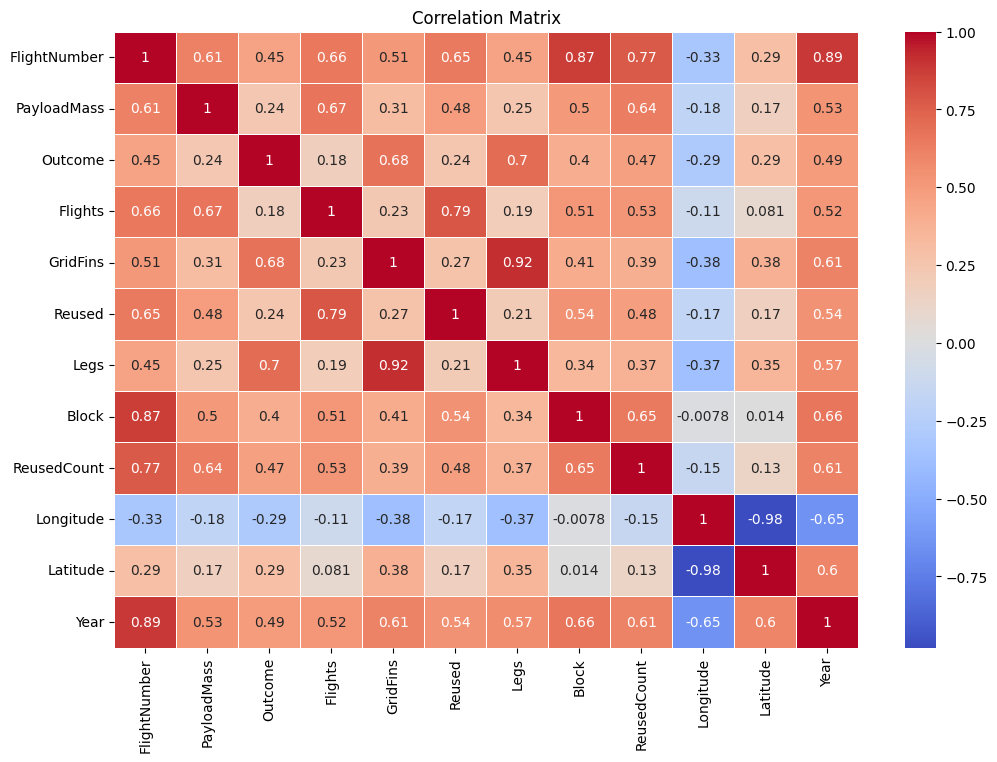

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data_filled.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()




In [52]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

# 创建Dash应用程序
app = dash.Dash(__name__)

# 加载数据
data = data_filled.copy()

# 创建图表
fig_payload_mass = px.histogram(data, x='PayloadMass', nbins=30, title='Distribution of PayloadMass')
fig_correlation = px.imshow(data.corr(), title='Correlation Matrix', color_continuous_scale='Viridis')

# 定义应用程序的布局
app.layout = html.Div(children=[
    html.H1(children='SpaceX Launch Data Dashboard'),
    
    html.Div(children='''
        Explore the SpaceX launch data.
    '''),
    
    dcc.Graph(
        id='correlation-matrix',
        figure=fig_correlation
    )
])

# 运行应用程序
if __name__ == '__main__':
    app.run_server(debug=True)





C:\Users\Quchang\AppData\Local\Temp\ipykernel_30800\1133016448.py:15: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [17]:
# Import the Folium library
import folium

# Create a map centered around coordinates [36.5054, -117.0794] (Death Valley, California)
m = folium.Map(location=[36.5054, -117.0794], zoom_start=10)

# Add a marker for Death Valley
folium.Marker([36.5054, -117.0794], popup='Death Valley').add_to(m)

# Add a circle around Death Valley
folium.Circle(
    radius=5000,  # in meters
    location=[36.5054, -117.0794],
    popup='Death Valley Circle',
    color='blue',
    fill=True,
).add_to(m)

# Assume that you've used Google Maps API to find the number of nearby roads, which is 2 for this example
num_roads = 2
folium.Marker([36.5054, -117.0794], 
              popup=f'Death Valley: {num_roads} nearby roads', 
              icon=folium.Icon(color="green")).add_to(m)

# Show the map
m



